# Experiments based on ASCAD (protected)
```AES-128 implementation masked with RSM-alike 1st order boolean mask.```

In [1]:
import numpy as np
import os
from src.utils import Sbox, coeff
import matplotlib.pyplot as plt
import random
from src.augmentations import addClockJitter, addDesync
from src.sample import traces_random_start, traces_raw
import sys
sys.path.append("..") 

num_train = 50000
num_valid = 5000
num_attack = 5000
trace_offset = 46000
trace_length = 2000
path = '/run/media/declan/sda1/open_dataset/ASCAD/ASCAD_fixedkey/'

folder_path = path+'/ACNN/pre-aug'
os.makedirs(folder_path,exist_ok=True)

aug_folder_path = path+'/ACNN/post-aug'
os.makedirs(aug_folder_path, exist_ok=True)

attack_c1_folder_path = path+'/ACNN/attack/c1'
os.makedirs(attack_c1_folder_path, exist_ok=True)

attack_c2_folder_path = path+'/ACNN/attack/c2'
os.makedirs(attack_c2_folder_path, exist_ok=True)

# Profiling
> loading ASCAD traces
>> training/validation set: (50000, 2000)/(5000, 2000)  
>> attacking set: (5000, 60000)

## file loader

In [2]:
import h5py
import sys
import numpy as np


def load_ascad(ascad_database_file, num_train, num_attack, begin, end):
    # Open the ASCAD database HDF5 for reading
    try:
        in_file = h5py.File(ascad_database_file, "r")
    except:
        print("Error: can't open HDF5 file '%s' for reading (it might be malformed) ..." %
                ascad_database_file)
        sys.exit(-1)

    X_train = np.array(in_file['traces'][:num_train, begin:end], dtype=np.float32) # segmented training traces
    X_attack = np.array(in_file['traces'][num_train:num_train+num_attack, :], dtype=np.float32) # raw attack traces

    R_train = np.array(in_file['metadata']['masks'][:num_train, 0])
    R_attack = np.array(in_file['metadata']['masks'][num_train:num_train+num_attack, :-2])
    R_attack = np.concatenate([np.zeros([len(R_attack), 2]), R_attack], axis=1)

    P_train = np.array(in_file['metadata']['plaintext'][:num_train, 2])
    P_attack = np.array(in_file['metadata']['plaintext'][num_train:num_train+num_attack])

    return X_train, X_attack, R_train, R_attack, P_train, P_attack

## Class Label

In [3]:


path_dataset = '/run/media/declan/sda1/open_dataset/ASCAD/ASCAD_fixedkey/ATMega8515_raw_traces.h5'

X_train, X_attack, R_train, R_attack, P_train, P_attack \
    = load_ascad(path_dataset, num_train+num_valid, num_attack, trace_offset, trace_offset+trace_length)
key = [77, 251, 224, 242, 114, 33, 254, 16, 167, 141, 74, 220, 142, 73, 4, 105]

Y_train = Sbox[P_train ^ key[2]]
Y_attack = Sbox[P_attack ^ key]

np.save(folder_path+'/X_train.npy',X_train)
np.save(folder_path+'/Y_train.npy',Y_train)
np.save(folder_path+'/X_attack.npy',X_attack)
np.save(folder_path+'/Y_attack.npy',Y_attack)
np.save(folder_path+'/R_train.npy', R_train)
np.save(folder_path+'/R_attack.npy', R_attack)
np.save(folder_path+'/P_train.npy',P_train)
np.save(folder_path+'/P_attack.npy',P_attack)
print(X_train.shape, Y_train.shape, R_train.shape, P_train.shape)
print(X_attack.shape, Y_attack.shape, R_attack.shape, P_train.shape)

(55000, 2000) (55000,) (55000,) (55000,)
(5000, 100000) (5000, 16) (5000, 16) (55000,)


## AOI Label

### Locating

In [4]:
X_train = np.load(folder_path+'/X_train.npy')[:10000]
Y_train = np.load(folder_path+'/Y_train.npy')[:10000]
R_train = np.load(folder_path+'/R_train.npy')[:10000]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


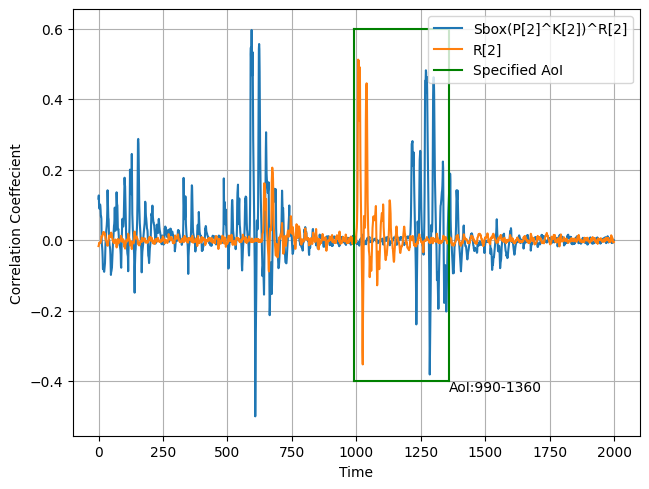

In [5]:
masked = Y_train ^ R_train

co1 = coeff(X_train.T, masked)
co2 = coeff(X_train.T, R_train)

plt.plot(co1, label='Sbox(P[2]^K[2])^R[2]')
plt.plot(co2, label='R[2]')
ps, pe = 990, 1360
pr = pe - ps
plt.plot([ps,ps], [-0.4,0.6], color='g', label='Specified AoI')
plt.plot([pe,pe], [-0.4,0.6], color='g')
plt.plot([ps,pe], [-0.4,-0.4], color='g')
plt.plot([ps,pe], [0.6,0.6], color='g')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.ylabel('Correlation Coeffecient')
plt.xlabel('Time')
plt.text(pe, -0.43, f'AoI:{ps}-{pe}')
plt.savefig('./output/AOI_ASCAD.eps', format='eps')

## augmentation

In [6]:
Xt = np.load(folder_path+'/X_train.npy')
Yt = np.load(folder_path+'/Y_train.npy').reshape(-1,1)

Xt_newpspe, Xt_jitter_trs = addClockJitter(Xt, [ps, pe], 2000, 1)
Xt_desync_offset_1, Xt_augment_trs = addDesync(Xt_jitter_trs, max_desync=108)

Xt_desync_offset_2, Xt_trs = addDesync(Xt, max_desync=108)

Xt_augment_trs = np.concatenate((Xt_augment_trs, Xt_trs), axis=0)
print(Xt_augment_trs.shape)

(110000, 2000)


## Label

In [7]:
# label for training and validation set: (ps, pr, class)
ps1, pe1 = Xt_newpspe[:,0:1], Xt_newpspe[:,1:2] # ps, pe after addClockJitter

pr1 = pe1 - ps1
ps1 = ps1 - Xt_desync_offset_1.reshape(-1, 1) # Desyn only change ps

pr2 = (np.ones_like(Yt)*pr)
ps2 = np.ones_like(Yt)*ps - Xt_desync_offset_2.reshape(-1, 1)

Yt_det = np.concatenate([np.concatenate((ps1+pr1//2, ps2+pr1//2),0),
                         np.concatenate((pr1, pr2),0),
                         np.concatenate((Yt, Yt),0)], 1)
                         
# randomly shift the post-augmented traces
l = list(zip(Xt_augment_trs, Yt_det))
random.shuffle(l)
Xt_augment_trs, Yt_det = list(zip(*l))
Xt_augment_trs, Yt_det = np.array(Xt_augment_trs), np.array(Yt_det)

In [8]:
# split into training and validation set
np.save(aug_folder_path+'/X_train.npy', Xt_augment_trs[:num_train*2])
np.save(aug_folder_path+'/X_valid.npy', Xt_augment_trs[num_train*2:])
np.save(aug_folder_path+'/Y_train.npy', Yt_det[:num_train*2])
np.save(aug_folder_path+'/Y_valid.npy', Yt_det[num_train*2:])

print(Xt_augment_trs.shape)
print(Yt_det.shape)
# so far, the preparation has completed.

(110000, 2000)
(110000, 3)


# Trainning

In [9]:
%%bash

python ./src/train.py --file_path='/run/media/declan/sda1/open_dataset/ASCAD/ASCAD_fixedkey/ACNN/post-aug' \
                --model_save='./models' \
                --epoch=50 \
                --name=ASCAD \
                --lr=1e-3 \
                --batch_size=256 \
                --trace_length=2000 \
                --nb_train=90000 \
                --nb_valid=5000 \
                --nb_class=256 \
                --stride=108 \
                --weight_decay=1e-8 \

Environment information:
System: Linux 5.15.133-1-MANJARO
Not using the poetry package
Current Commit Hash: 930b7f7
Command line arguments: Namespace(file_path='/run/media/declan/sda1/open_dataset/ASCAD/ASCAD_fixedkey/ACNN/post-aug', model_save='./models', epochs=50, model=None, name='ASCAD', lr=0.001, batch_size=256, weight_decay=1e-08, seed=1, verbose=True, trace_length=2000, nb_train=90000, nb_valid=5000, nb_class=256, stride=108)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 4, 2000]              24
       BatchNorm1d-2              [-1, 4, 2000]               8
         LeakyReLU-3              [-1, 4, 2000]               0
         MaxPool1d-4               [-1, 4, 666]               0
            Conv1d-5               [-1, 8, 666]             168
       BatchNorm1d-6               [-1, 8, 666]              16
         LeakyReLU-7               [-1, 8, 666]  

Training Epoch 1: 100%|██████████| 352/352 [00:02<00:00, 129.42it/s]



---- Evaluating Model ----


Validation Epoch 1: 100%|██████████| 20/20 [00:00<00:00, 137.85it/s]


Epoch-1
+--------------+---------------------+----------------------+
| Loss&Metric  | Train               | Validation           |
+--------------+---------------------+----------------------+
| leak loss    | 0.03002136454134333 | 0.007433703052811325 |
| no_leak loss | 0.07198413701156493 | 0.02502070888876915  |
| IoU loss     | 0.10380345153283667 | 0.05456335432827473  |
| class loss   | 5.555830210447311   | 5.548754739761352    |
| total loss   | 6.169661165638403   | 5.765590190887451    |
+--------------+---------------------+----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 2: 100%|██████████| 352/352 [00:02<00:00, 136.27it/s]



---- Evaluating Model ----


Validation Epoch 2: 100%|██████████| 20/20 [00:00<00:00, 147.59it/s]


Epoch-2
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.008114997250562406 | 0.004102535400306806 |
| no_leak loss | 0.015425569547170942 | 0.015218673180788756 |
| IoU loss     | 0.04890536230099811  | 0.04255984090268612  |
| class loss   | 5.54766566103155     | 5.544240784645081    |
| total loss   | 5.714273852380839    | 5.683406662940979    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 3: 100%|██████████| 352/352 [00:02<00:00, 137.56it/s]



---- Evaluating Model ----


Validation Epoch 3: 100%|██████████| 20/20 [00:00<00:00, 148.70it/s]


Epoch-3
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.005474867167570416 | 0.004813168395776302 |
| no_leak loss | 0.011426465905969962 | 0.010219333926215768 |
| IoU loss     | 0.0420769608727741   | 0.041423726826906204 |
| class loss   | 5.544637728821147    | 5.545670890808106    |
| total loss   | 5.671221348372373    | 5.662257122993469    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 4: 100%|██████████| 352/352 [00:02<00:00, 137.47it/s]



---- Evaluating Model ----


Validation Epoch 4: 100%|██████████| 20/20 [00:00<00:00, 146.75it/s]


Epoch-4
+--------------+---------------------+----------------------+
| Loss&Metric  | Train               | Validation           |
+--------------+---------------------+----------------------+
| leak loss    | 0.00446777811025227 | 0.005252843024209142 |
| no_leak loss | 0.01015397643839771 | 0.00841561732813716  |
| IoU loss     | 0.03773303048431196 | 0.03517853636294603  |
| class loss   | 5.543707992542874   | 5.545285058021546    |
| total loss   | 5.654549797827547   | 5.64880588054657     |
+--------------+---------------------+----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 5: 100%|██████████| 352/352 [00:02<00:00, 138.47it/s]



---- Evaluating Model ----


Validation Epoch 5: 100%|██████████| 20/20 [00:00<00:00, 149.88it/s]


Epoch-5
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.003988565549165783 | 0.002770730367046781 |
| no_leak loss | 0.009485355967295949 | 0.010069848177954555 |
| IoU loss     | 0.03577100242678584  | 0.03338233064860106  |
| class loss   | 5.543384178118273    | 5.544197201728821    |
| total loss   | 5.646524784239856    | 5.641782426834107    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 6: 100%|██████████| 352/352 [00:02<00:00, 137.91it/s]



---- Evaluating Model ----


Validation Epoch 6: 100%|██████████| 20/20 [00:00<00:00, 148.56it/s]


Epoch-6
+--------------+-----------------------+---------------------+
| Loss&Metric  | Train                 | Validation          |
+--------------+-----------------------+---------------------+
| leak loss    | 0.0036021715546997834 | 0.00208234537858516 |
| no_leak loss | 0.009092631337063556  | 0.01094079650938511 |
| IoU loss     | 0.03407739270055159   | 0.0325831008143723  |
| class loss   | 5.543159954927185     | 5.544242429733276   |
| total loss   | 5.640711357647723     | 5.6419412851333615  |
+--------------+-----------------------+---------------------+

---- Training Model ----


Training Epoch 7: 100%|██████████| 352/352 [00:02<00:00, 135.89it/s]



---- Evaluating Model ----


Validation Epoch 7: 100%|██████████| 20/20 [00:00<00:00, 146.47it/s]


Epoch-7
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0034658788905620563 | 0.0034920026955660433 |
| no_leak loss | 0.0087795025954785    | 0.007968174456618727  |
| IoU loss     | 0.03307629545981234   | 0.03434009924530983   |
| class loss   | 5.542906640605493     | 5.544460463523865     |
| total loss   | 5.637209840796211     | 5.636101460456848     |
+--------------+-----------------------+-----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 8: 100%|██████████| 352/352 [00:02<00:00, 136.01it/s]



---- Evaluating Model ----


Validation Epoch 8: 100%|██████████| 20/20 [00:00<00:00, 149.19it/s]


Epoch-8
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0032658310185731602 | 0.0022460868407506497 |
| no_leak loss | 0.008602569875868292  | 0.009106078837066888  |
| IoU loss     | 0.03231914369495247   | 0.035088200122117996  |
| class loss   | 5.542540368708697     | 5.544970202445984     |
| total loss   | 5.634201509031382     | 5.636819219589233     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 9: 100%|██████████| 352/352 [00:02<00:00, 135.30it/s]



---- Evaluating Model ----


Validation Epoch 9: 100%|██████████| 20/20 [00:00<00:00, 153.28it/s]


Epoch-9
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.003145310060352296 | 0.004729353776201606 |
| no_leak loss | 0.0084357187284199   | 0.006634649029001594 |
| IoU loss     | 0.03133316769328138  | 0.030976711865514518 |
| class loss   | 5.541871238838542    | 5.544775867462159    |
| total loss   | 5.631109551949934    | 5.632572627067566    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 10: 100%|██████████| 352/352 [00:02<00:00, 137.03it/s]



---- Evaluating Model ----


Validation Epoch 10: 100%|██████████| 20/20 [00:00<00:00, 150.28it/s]


Epoch-10
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.003074897973502547 | 0.0029614275321364404 |
| no_leak loss | 0.008338432651891542 | 0.007999096647836268  |
| IoU loss     | 0.030956403876189142 | 0.029646527022123337  |
| class loss   | 5.541034434329379    | 5.545112538337707     |
| total loss   | 5.629057488658211    | 5.629561734199524     |
+--------------+----------------------+-----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 11: 100%|██████████| 352/352 [00:02<00:00, 135.22it/s]



---- Evaluating Model ----


Validation Epoch 11: 100%|██████████| 20/20 [00:00<00:00, 150.18it/s]


Epoch-11
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0029886642443505643 | 0.0046130595030263065 |
| no_leak loss | 0.008191573278798553  | 0.006611857074312865  |
| IoU loss     | 0.0300210959976539    | 0.036197468265891077  |
| class loss   | 5.539984838529066     | 5.544292402267456     |
| total loss   | 5.625907117670232     | 5.636614465713501     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 12: 100%|██████████| 352/352 [00:02<00:00, 135.87it/s]



---- Evaluating Model ----


Validation Epoch 12: 100%|██████████| 20/20 [00:00<00:00, 150.00it/s]


Epoch-12
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0030245500531071393 | 0.002565845547360368 |
| no_leak loss | 0.00816045447638978   | 0.008176685869693756 |
| IoU loss     | 0.029560809161260047  | 0.029078482557088135 |
| class loss   | 5.537892004305666     | 5.544028115272522    |
| total loss   | 5.623377840627324     | 5.626819276809693    |
+--------------+-----------------------+----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 13: 100%|██████████| 352/352 [00:02<00:00, 135.08it/s]



---- Evaluating Model ----


Validation Epoch 13: 100%|██████████| 20/20 [00:00<00:00, 149.10it/s]


Epoch-13
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.003011669213595848 | 0.004892652214039117 |
| no_leak loss | 0.008117895635553974 | 0.006440224079415202 |
| IoU loss     | 0.02954758314246481  | 0.034016731567680834 |
| class loss   | 5.532222051512111    | 5.528030586242676    |
| total loss   | 5.6174174547195435   | 5.618711638450622    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 14: 100%|██████████| 352/352 [00:02<00:00, 135.55it/s]



---- Evaluating Model ----


Validation Epoch 14: 100%|██████████| 20/20 [00:00<00:00, 148.24it/s]


Epoch-14
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0031941426156911553 | 0.003949710133019835 |
| no_leak loss | 0.00823442532220559   | 0.007245506206527352 |
| IoU loss     | 0.02981416584754532   | 0.030218780133873226 |
| class loss   | 5.496516613797708     | 5.475287985801697    |
| total loss   | 5.5834736078977585    | 5.561482858657837    |
+--------------+-----------------------+----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 15: 100%|██████████| 352/352 [00:02<00:00, 135.91it/s]



---- Evaluating Model ----


Validation Epoch 15: 100%|██████████| 20/20 [00:00<00:00, 149.81it/s]


Epoch-15
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.003097230507343986 | 0.002395475679077208 |
| no_leak loss | 0.008197973717787218 | 0.008602942852303386 |
| IoU loss     | 0.030355925761713563 | 0.029713011905550958 |
| class loss   | 5.458436933430758    | 5.450105690956116    |
| total loss   | 5.545268893241882    | 5.53481080532074     |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 16: 100%|██████████| 352/352 [00:02<00:00, 136.31it/s]



---- Evaluating Model ----


Validation Epoch 16: 100%|██████████| 20/20 [00:00<00:00, 144.70it/s]


Epoch-16
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0030241320962225223 | 0.0025442292462685145 |
| no_leak loss | 0.00817480656339533   | 0.008267888729460538  |
| IoU loss     | 0.030276265286374837  | 0.02883541826158762   |
| class loss   | 5.443157328800722     | 5.43917019367218      |
| total loss   | 5.529428274794058     | 5.5220661640167235    |
+--------------+-----------------------+-----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 17: 100%|██████████| 352/352 [00:02<00:00, 134.43it/s]



---- Evaluating Model ----


Validation Epoch 17: 100%|██████████| 20/20 [00:00<00:00, 149.25it/s]


Epoch-17
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0029859996172738397 | 0.0028016069496516137 |
| no_leak loss | 0.008063835537706671  | 0.008080338151194156  |
| IoU loss     | 0.030005259968509727  | 0.029551205784082414  |
| class loss   | 5.436094262383201     | 5.435465455055237     |
| total loss   | 5.521348697218028     | 5.519426441192627     |
+--------------+-----------------------+-----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 18: 100%|██████████| 352/352 [00:02<00:00, 135.70it/s]



---- Evaluating Model ----


Validation Epoch 18: 100%|██████████| 20/20 [00:00<00:00, 153.55it/s]


Epoch-18
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0029845103511599354 | 0.0032533547870116307 |
| no_leak loss | 0.008014946090539028  | 0.0077104679308831695 |
| IoU loss     | 0.029930999761828305  | 0.029511167760938407  |
| class loss   | 5.429364900697362     | 5.432928919792175     |
| total loss   | 5.51429318162528      | 5.517259192466736     |
+--------------+-----------------------+-----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 19: 100%|██████████| 352/352 [00:02<00:00, 137.27it/s]



---- Evaluating Model ----


Validation Epoch 19: 100%|██████████| 20/20 [00:00<00:00, 152.35it/s]


Epoch-19
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0029159808509162262 | 0.0027953115990385414 |
| no_leak loss | 0.007961461078428494  | 0.007896797498688102  |
| IoU loss     | 0.02948167858200825   | 0.028508147038519383  |
| class loss   | 5.4258173961531035    | 5.442091655731201     |
| total loss   | 5.509686291217804     | 5.5240602731704715    |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 20: 100%|██████████| 352/352 [00:02<00:00, 136.38it/s]



---- Evaluating Model ----


Validation Epoch 20: 100%|██████████| 20/20 [00:00<00:00, 145.84it/s]


Epoch-20
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.002897231712267967 | 0.002846887397754472 |
| no_leak loss | 0.007996338080953468 | 0.007924409676343202 |
| IoU loss     | 0.029317153903486378 | 0.029124913923442363 |
| class loss   | 5.422312166203152    | 5.43137047290802     |
| total loss   | 5.5060971704396335   | 5.514351820945739    |
+--------------+----------------------+----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 21: 100%|██████████| 352/352 [00:02<00:00, 134.47it/s]



---- Evaluating Model ----


Validation Epoch 21: 100%|██████████| 20/20 [00:00<00:00, 152.46it/s]


Epoch-21
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0028721828687346056 | 0.0031944393180310727 |
| no_leak loss | 0.007957647856859363  | 0.007433311687782407  |
| IoU loss     | 0.029522705161732367  | 0.028012852557003497  |
| class loss   | 5.417891689322212     | 5.4382854223251345    |
| total loss   | 5.501563547687097     | 5.519437050819397     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 22: 100%|██████████| 352/352 [00:02<00:00, 133.48it/s]



---- Evaluating Model ----


Validation Epoch 22: 100%|██████████| 20/20 [00:00<00:00, 130.11it/s]


Epoch-22
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0028448285603934146 | 0.0028050633176462726 |
| no_leak loss | 0.00791465066537388   | 0.007807171274907887  |
| IoU loss     | 0.029170331931461325  | 0.033417653571814296  |
| class loss   | 5.4151384017684245    | 5.429967617988586     |
| total loss   | 5.498106124726209     | 5.516446423530579     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 23: 100%|██████████| 352/352 [00:02<00:00, 135.76it/s]



---- Evaluating Model ----


Validation Epoch 23: 100%|██████████| 20/20 [00:00<00:00, 151.31it/s]


Epoch-23
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0028775632321081835 | 0.0040598440042231235 |
| no_leak loss | 0.0078941974603698    | 0.0067297952016815545 |
| IoU loss     | 0.029454847644294867  | 0.029373019095510246  |
| class loss   | 5.412709045139226     | 5.428934574127197     |
| total loss   | 5.49602270397273      | 5.512255716323852     |
+--------------+-----------------------+-----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 24: 100%|██████████| 352/352 [00:02<00:00, 136.69it/s]



---- Evaluating Model ----


Validation Epoch 24: 100%|██████████| 20/20 [00:00<00:00, 152.66it/s]


Epoch-24
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0027783814283462893 | 0.003174566487723496 |
| no_leak loss | 0.007896444339580326  | 0.007347275083884597 |
| IoU loss     | 0.028626186709681697  | 0.030486868042498828 |
| class loss   | 5.409464651888067     | 5.426706480979919    |
| total loss   | 5.491464979269288     | 5.5098025560379025   |
+--------------+-----------------------+----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 25: 100%|██████████| 352/352 [00:02<00:00, 136.81it/s]



---- Evaluating Model ----


Validation Epoch 25: 100%|██████████| 20/20 [00:00<00:00, 152.32it/s]


Epoch-25
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.002819046734078835 | 0.0024708781944354995 |
| no_leak loss | 0.007819340839474038 | 0.008377449330873787  |
| IoU loss     | 0.02882212766086344  | 0.030313391145318745  |
| class loss   | 5.407530191269788    | 5.426730060577393     |
| total loss   | 5.489544261585582    | 5.5112850904464725    |
+--------------+----------------------+-----------------------+

---- Training Model ----


Training Epoch 26: 100%|██████████| 352/352 [00:02<00:00, 136.38it/s]



---- Evaluating Model ----


Validation Epoch 26: 100%|██████████| 20/20 [00:00<00:00, 152.16it/s]


Epoch-26
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0028020220908150473 | 0.002090085265808739 |
| no_leak loss | 0.007855399210132997  | 0.008763979515060782 |
| IoU loss     | 0.0285475846612826    | 0.02853594785556197  |
| class loss   | 5.40469294515523      | 5.424491739273071    |
| total loss   | 5.486527642065829     | 5.507297992706299    |
+--------------+-----------------------+----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 27: 100%|██████████| 352/352 [00:02<00:00, 136.65it/s]



---- Evaluating Model ----


Validation Epoch 27: 100%|██████████| 20/20 [00:00<00:00, 152.46it/s]


Epoch-27
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0027318860407541997 | 0.0025847742828773333 |
| no_leak loss | 0.007828491987311281  | 0.007976721064187587  |
| IoU loss     | 0.028711209989110517  | 0.027900942880660296  |
| class loss   | 5.403517186641693     | 5.431561303138733     |
| total loss   | 5.485030289400708     | 5.512269735336304     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 28: 100%|██████████| 352/352 [00:02<00:00, 137.45it/s]



---- Evaluating Model ----


Validation Epoch 28: 100%|██████████| 20/20 [00:00<00:00, 151.46it/s]


Epoch-28
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0027596894943103093 | 0.0031711593983345665 |
| no_leak loss | 0.007821086278206414  | 0.007693917653523385  |
| IoU loss     | 0.02843423456546258   | 0.029765732958912848  |
| class loss   | 5.402745714241808     | 5.430587291717529     |
| total loss   | 5.484083838083527     | 5.514678430557251     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 29: 100%|██████████| 352/352 [00:02<00:00, 136.21it/s]



---- Evaluating Model ----


Validation Epoch 29: 100%|██████████| 20/20 [00:00<00:00, 151.06it/s]


Epoch-29
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.002745709761752964 | 0.0035283512057503684 |
| no_leak loss | 0.007785653317114338 | 0.007137638051062822  |
| IoU loss     | 0.0284610256891359   | 0.028743979521095753  |
| class loss   | 5.3997937806627965   | 5.424012780189514     |
| total loss   | 5.480911617929285    | 5.506086683273315     |
+--------------+----------------------+-----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 30: 100%|██████████| 352/352 [00:02<00:00, 136.76it/s]



---- Evaluating Model ----


Validation Epoch 30: 100%|██████████| 20/20 [00:00<00:00, 152.75it/s]


Epoch-30
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0026888167253260194 | 0.003389613374019973 |
| no_leak loss | 0.007790035199088214  | 0.007126967655494809 |
| IoU loss     | 0.02816650364547968   | 0.027642115764319897 |
| class loss   | 5.3991951983083375    | 5.4225942373275755   |
| total loss   | 5.479755961082199     | 5.50281925201416     |
+--------------+-----------------------+----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 31: 100%|██████████| 352/352 [00:02<00:00, 137.83it/s]



---- Evaluating Model ----


Validation Epoch 31: 100%|██████████| 20/20 [00:00<00:00, 147.32it/s]


Epoch-31
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0026272196088774017 | 0.0019102185637166259 |
| no_leak loss | 0.007807076661265455  | 0.009417913458310067  |
| IoU loss     | 0.028212439845612444  | 0.02924255933612585   |
| class loss   | 5.396716885946014     | 5.423955345153809     |
| total loss   | 5.477100809866732     | 5.509838509559631     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 32: 100%|██████████| 352/352 [00:02<00:00, 137.21it/s]



---- Evaluating Model ----


Validation Epoch 32: 100%|██████████| 20/20 [00:00<00:00, 151.95it/s]


Epoch-32
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0027012217840572043 | 0.002548121253494173 |
| no_leak loss | 0.0078023327183803885 | 0.008324320428073406 |
| IoU loss     | 0.02817821856164797   | 0.02831521462649107  |
| class loss   | 5.395001173019409     | 5.4260920763015745   |
| total loss   | 5.475697170604359     | 5.508769464492798    |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 33: 100%|██████████| 352/352 [00:02<00:00, 136.85it/s]



---- Evaluating Model ----


Validation Epoch 33: 100%|██████████| 20/20 [00:00<00:00, 150.88it/s]


Epoch-33
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0026603675299322112 | 0.002386938949348405 |
| no_leak loss | 0.007800904267986136  | 0.00829188923817128  |
| IoU loss     | 0.02809691394213587   | 0.028542816173285246 |
| class loss   | 5.394485092975876     | 5.4214928150177      |
| total loss   | 5.474888369441032     | 5.503429794311524    |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 34: 100%|██████████| 352/352 [00:02<00:00, 138.01it/s]



---- Evaluating Model ----


Validation Epoch 34: 100%|██████████| 20/20 [00:00<00:00, 152.86it/s]


Epoch-34
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0026651752613030444 | 0.0026017850410426035 |
| no_leak loss | 0.007767329081120392  | 0.007894618203863502  |
| IoU loss     | 0.02796239911747927   | 0.02888661911711097   |
| class loss   | 5.391923224384135     | 5.421071004867554     |
| total loss   | 5.472048143094236     | 5.502439641952515     |
+--------------+-----------------------+-----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 35: 100%|██████████| 352/352 [00:02<00:00, 137.10it/s]



---- Evaluating Model ----


Validation Epoch 35: 100%|██████████| 20/20 [00:00<00:00, 152.28it/s]


Epoch-35
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0026865436870428475 | 0.002532574475480942 |
| no_leak loss | 0.007746228748477402  | 0.00792033108882606  |
| IoU loss     | 0.028118246790571986  | 0.029114227183163165 |
| class loss   | 5.391055848110806     | 5.426906657218933    |
| total loss   | 5.471337967298248     | 5.508285403251648    |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 36: 100%|██████████| 352/352 [00:02<00:00, 136.80it/s]



---- Evaluating Model ----


Validation Epoch 36: 100%|██████████| 20/20 [00:00<00:00, 152.24it/s]


Epoch-36
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.002597055182460198 | 0.00363870331493672  |
| no_leak loss | 0.007747412511062893 | 0.006933923065662384 |
| IoU loss     | 0.027881049270614643 | 0.02881609434261918  |
| class loss   | 5.389585409652103    | 5.437866163253784    |
| total loss   | 5.469188793139025    | 5.5195454359054565   |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 37: 100%|██████████| 352/352 [00:02<00:00, 136.56it/s]



---- Evaluating Model ----


Validation Epoch 37: 100%|██████████| 20/20 [00:00<00:00, 152.30it/s]


Epoch-37
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.002598434765166696 | 0.0037254191294778137 |
| no_leak loss | 0.007735771545081992 | 0.007118940632790327  |
| IoU loss     | 0.02787869271229614  | 0.028370680287480354  |
| class loss   | 5.387808461080898    | 5.421310877799987     |
| total loss   | 5.467358177358454    | 5.503903412818909     |
+--------------+----------------------+-----------------------+

---- Training Model ----


Training Epoch 38: 100%|██████████| 352/352 [00:02<00:00, 137.29it/s]



---- Evaluating Model ----


Validation Epoch 38: 100%|██████████| 20/20 [00:00<00:00, 150.58it/s]


Epoch-38
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0026291209906462013 | 0.003787799569545314 |
| no_leak loss | 0.007731713166735558  | 0.006573435640893877 |
| IoU loss     | 0.027840624113609505  | 0.02938495920971036  |
| class loss   | 5.386824376203797     | 5.423940634727478    |
| total loss   | 5.46646918898279      | 5.50513174533844     |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 39: 100%|██████████| 352/352 [00:02<00:00, 136.82it/s]



---- Evaluating Model ----


Validation Epoch 39: 100%|██████████| 20/20 [00:00<00:00, 150.20it/s]


Epoch-39
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0026044834502995814 | 0.0028475401923060417 |
| no_leak loss | 0.007709462009105747  | 0.007425755658186972  |
| IoU loss     | 0.027917869479014455  | 0.027525923494249583  |
| class loss   | 5.386107527396896     | 5.425296521186828     |
| total loss   | 5.465595126152039     | 5.504188871383667     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 40: 100%|██████████| 352/352 [00:02<00:00, 137.71it/s]



---- Evaluating Model ----


Validation Epoch 40: 100%|██████████| 20/20 [00:00<00:00, 151.75it/s]


Epoch-40
+--------------+----------------------+----------------------+
| Loss&Metric  | Train                | Validation           |
+--------------+----------------------+----------------------+
| leak loss    | 0.002625616123747353 | 0.00434655801509507  |
| no_leak loss | 0.007706990226076662 | 0.006464147637598216 |
| IoU loss     | 0.027688830233687026 | 0.02746072979643941  |
| class loss   | 5.3848695064132865   | 5.4339282512664795   |
| total loss   | 5.46422136507251     | 5.515442562103272    |
+--------------+----------------------+----------------------+

---- Training Model ----


Training Epoch 41: 100%|██████████| 352/352 [00:02<00:00, 136.41it/s]



---- Evaluating Model ----


Validation Epoch 41: 100%|██████████| 20/20 [00:00<00:00, 149.45it/s]


Epoch-41
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0025687487674820823 | 0.004027116083307192 |
| no_leak loss | 0.007698438621115532  | 0.006592376111075282 |
| IoU loss     | 0.02779053180711344   | 0.027478426974266768 |
| class loss   | 5.383401288227602     | 5.424426698684693    |
| total loss   | 5.462527747858655     | 5.50500259399414     |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 42: 100%|██████████| 352/352 [00:02<00:00, 136.20it/s]



---- Evaluating Model ----


Validation Epoch 42: 100%|██████████| 20/20 [00:00<00:00, 152.39it/s]


Epoch-42
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0026046421076402607 | 0.0038407780055422338 |
| no_leak loss | 0.007738716559040106  | 0.007036547595635057  |
| IoU loss     | 0.02770499875557355   | 0.027715980354696513  |
| class loss   | 5.381582155823708     | 5.4332190990448       |
| total loss   | 5.461003945632414     | 5.515321683883667     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 43: 100%|██████████| 352/352 [00:02<00:00, 137.40it/s]



---- Evaluating Model ----


Validation Epoch 43: 100%|██████████| 20/20 [00:00<00:00, 152.83it/s]


Epoch-43
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0025790129184728853 | 0.0028701740917313145 |
| no_leak loss | 0.007687917980630035  | 0.007588828401640058  |
| IoU loss     | 0.027533797388473016  | 0.02773538026958704   |
| class loss   | 5.38163336976008      | 5.416353559494018     |
| total loss   | 5.460501802238551     | 5.496383905410767     |
+--------------+-----------------------+-----------------------+
---- Saving checkpoint to: './models/ASCAD_best.pth' ----

---- Training Model ----


Training Epoch 44: 100%|██████████| 352/352 [00:02<00:00, 137.79it/s]



---- Evaluating Model ----


Validation Epoch 44: 100%|██████████| 20/20 [00:00<00:00, 149.81it/s]


Epoch-44
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.002582666955277091 | 0.0031544599391054363 |
| no_leak loss | 0.007692889135796577 | 0.007306263945065439  |
| IoU loss     | 0.02755373742812398  | 0.027980661764740945  |
| class loss   | 5.3793900216167625   | 5.425761961936951     |
| total loss   | 5.458321542902426    | 5.506046271324157     |
+--------------+----------------------+-----------------------+

---- Training Model ----


Training Epoch 45: 100%|██████████| 352/352 [00:02<00:00, 136.61it/s]



---- Evaluating Model ----


Validation Epoch 45: 100%|██████████| 20/20 [00:00<00:00, 149.85it/s]


Epoch-45
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.002553576010623973 | 0.0028805846552131696 |
| no_leak loss | 0.007682273766311648 | 0.007608626526780427  |
| IoU loss     | 0.02759411839493127  | 0.02740714494138956   |
| class loss   | 5.378193308006633    | 5.427986812591553     |
| total loss   | 5.456966667012735    | 5.507839965820312     |
+--------------+----------------------+-----------------------+

---- Training Model ----


Training Epoch 46: 100%|██████████| 352/352 [00:02<00:00, 136.56it/s]



---- Evaluating Model ----


Validation Epoch 46: 100%|██████████| 20/20 [00:00<00:00, 152.51it/s]


Epoch-46
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.002553331306909389 | 0.0034848953073378652 |
| no_leak loss | 0.007719967264248143 | 0.006964793149381876  |
| IoU loss     | 0.027498138893861324 | 0.027478014584630728  |
| class loss   | 5.377811832861467    | 5.431956696510315     |
| total loss   | 5.456676472317088    | 5.51168315410614      |
+--------------+----------------------+-----------------------+

---- Training Model ----


Training Epoch 47: 100%|██████████| 352/352 [00:02<00:00, 137.09it/s]



---- Evaluating Model ----


Validation Epoch 47: 100%|██████████| 20/20 [00:00<00:00, 150.56it/s]


Epoch-47
+--------------+-----------------------+----------------------+
| Loss&Metric  | Train                 | Validation           |
+--------------+-----------------------+----------------------+
| leak loss    | 0.0025451481612683642 | 0.00273102618593839  |
| no_leak loss | 0.0077077941413418475 | 0.007761979685164988 |
| IoU loss     | 0.02742727022004229   | 0.027113613206893206 |
| class loss   | 5.377502891150388     | 5.420352435111999    |
| total loss   | 5.45619487491521      | 5.499931120872498    |
+--------------+-----------------------+----------------------+

---- Training Model ----


Training Epoch 48: 100%|██████████| 352/352 [00:02<00:00, 137.20it/s]



---- Evaluating Model ----


Validation Epoch 48: 100%|██████████| 20/20 [00:00<00:00, 151.45it/s]


Epoch-48
+--------------+-----------------------+-----------------------+
| Loss&Metric  | Train                 | Validation            |
+--------------+-----------------------+-----------------------+
| leak loss    | 0.0025507796127302836 | 0.0033942203357582913 |
| no_leak loss | 0.007687189876874486  | 0.006711614597588777  |
| IoU loss     | 0.027647838605017485  | 0.028972399700433017  |
| class loss   | 5.374586285515265     | 5.418306970596314     |
| total loss   | 5.453423961997032     | 5.497808527946472     |
+--------------+-----------------------+-----------------------+

---- Training Model ----


Training Epoch 49: 100%|██████████| 352/352 [00:02<00:00, 136.14it/s]



---- Evaluating Model ----


Validation Epoch 49: 100%|██████████| 20/20 [00:00<00:00, 153.82it/s]


Epoch-49
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.002570992987226749 | 0.0028278307741857133 |
| no_leak loss | 0.007663406010992317 | 0.007844897895120084  |
| IoU loss     | 0.027585779327306558 | 0.028239408042281866  |
| class loss   | 5.374451294541359    | 5.418174982070923     |
| total loss   | 5.453209072351456    | 5.499778056144715     |
+--------------+----------------------+-----------------------+

---- Training Model ----


Training Epoch 50: 100%|██████████| 352/352 [00:02<00:00, 137.25it/s]



---- Evaluating Model ----


Validation Epoch 50: 100%|██████████| 20/20 [00:00<00:00, 153.17it/s]


Epoch-50
+--------------+----------------------+-----------------------+
| Loss&Metric  | Train                | Validation            |
+--------------+----------------------+-----------------------+
| leak loss    | 0.00255498967790531  | 0.0029920293876784855 |
| no_leak loss | 0.007667169617806477 | 0.00773469740524888   |
| IoU loss     | 0.02742617177268998  | 0.02785107269883156   |
| class loss   | 5.373568904670802    | 5.423066473007202     |
| total loss   | 5.452105864882469    | 5.504551196098328     |
+--------------+----------------------+-----------------------+


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


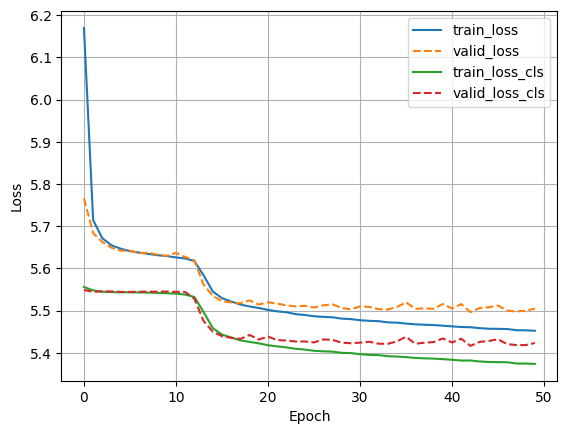

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

train_loss = pd.read_table('./output/train_loss_ASCAD.csv',sep=",")
valid_loss = pd.read_table('./output/valid_loss_ASCAD.csv',sep=",")

for i in ['loss','loss_cls']:
    h, = plt.plot(train_loss[i],'-',label='train_'+i)
    h, = plt.plot(valid_loss[i],'--',label='valid_'+i)
plt.legend()

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(True)
plt.savefig('./output/loss_ASCAD.eps', format='eps')

In [11]:
from src.model import ACNN_ASCAD
from src.utils import get_parameter_number

model = ACNN_ASCAD(256)
print(get_parameter_number(model))

the number of netwrok parameters: 9959, trainable parameters: 9959


# Attacking

### Case I

In [12]:
## Creating attacking set1.
Xa, Ya = np.load(folder_path+'/X_attack.npy'), np.load(folder_path+'/Y_attack.npy')[:, 2]
Pa = np.load(folder_path+'/P_attack.npy')[:, 2]
print(Xa.shape, Ya.shape, Pa.shape)
offset_c1, attack_trs_c1 = traces_random_start(traces=Xa, base=trace_offset, l=2000, max_offset=350)

ps, pe = 990, 1360
pr = pe - ps

# target AOI for attack traces 
attack_ps, attack_pr = ps*np.ones_like(offset_c1)-offset_c1, pr*np.ones_like(offset_c1)
attack_ps, attack_pr = attack_ps.reshape(-1,1), attack_pr.reshape(-1,1)
Ya = Ya.reshape(-1,1)
attack_label_c1 = np.concatenate([attack_ps+attack_pr//2, attack_pr, Ya], axis=1)

np.save(attack_c1_folder_path+'/X_attack.npy',attack_trs_c1)
np.save(attack_c1_folder_path+'/Y_attack.npy',attack_label_c1)
np.save(attack_c1_folder_path+'/P_attack.npy',Pa)
print(attack_trs_c1.shape, attack_label_c1.shape, Pa.shape)

(5000, 100000) (5000,) (5000,)
(5000, 2000) (5000, 3) (5000,)


In [10]:
%%bash

python ./src/test.py --file_path='/run/media/declan/sda1/open_dataset/ASCAD/ASCAD_fixedkey/ACNN/attack/c1' \
                --model='./models/ASCAD_best.pth' \
                --name=ASCAD \
                --batch_size=256 \
                --trace_length=2000 \
                --nb_class=256 \
                --nb_attack=500 \
                --trace_offset=0 \
                --thres_nms=0.6 \
                --thres_conf=0.85 \
                --max_det=2 \
                --key=224 \
                --stride=108 \
                --GE=True \
                --showinstance=3 \

Environment information:
System: Linux 5.15.133-1-MANJARO
Not using the poetry package
Current Commit Hash: 901a127
Command line arguments: Namespace(file_path='/run/media/declan/sda1/open_dataset/ASCAD/ASCAD_fixedkey/ACNN/attack/c1', model='./models/ASCAD_best.pth', name='ASCAD', batch_size=256, trace_length=2000, nb_class=256, nb_attack=500, trace_offset=0, thres_nms=0.6, thres_conf=0.85, max_det=2, key=224, stride=108, byte=None, frequency='False', showinstance=3, GE='True', save_plot='True')
Model saved from epoch-43


Testing: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### Case II

In [14]:
## Creating attacking set2.
Xa, Ya = np.load(folder_path+'/X_attack.npy'), np.load(folder_path+'/Y_attack.npy')[:, 2]
Pa = np.load(folder_path+'/P_attack.npy')[:, 2]
print(Xa.shape, Ya.shape, Pa.shape)
base = 10000
attack_trs_c2 = traces_raw(traces=Xa, base=base, l=50000)

ps, pe = 990, 1360
pr = pe - ps

ps_c2 = ps + (trace_offset-base)
# target AOI for attack traces 
attack_ps, attack_pr = ps_c2*np.ones([len(attack_trs_c2), 1]), pr*np.ones([len(attack_trs_c2), 1])
Ya = Ya.reshape(-1,1)
attack_label_c2 = np.concatenate([attack_ps+attack_pr//2, attack_pr, Ya], axis=1)

np.save(attack_c2_folder_path+'/X_attack.npy',attack_trs_c2)
np.save(attack_c2_folder_path+'/Y_attack.npy',attack_label_c2)
np.save(attack_c2_folder_path+'/P_attack.npy',Pa)
print(attack_trs_c2.shape, attack_label_c2.shape, Pa.shape)

(5000, 100000) (5000,) (5000,)
(5000, 50000) (5000, 3) (5000,)


In [9]:
%%bash

python ./src/test.py --file_path='/run/media/declan/sda1/open_dataset/ASCAD/ASCAD_fixedkey/ACNN/attack/c2' \
                --model='./models/ASCAD_best.pth' \
                --name=ASCAD \
                --batch_size=256 \
                --trace_length=50000 \
                --nb_class=256 \
                --nb_attack=500 \
                --trace_offset=10000 \
                --thres_nms=0.60 \
                --thres_conf=0.85 \
                --max_det=17 \
                --key=224 \
                --stride=108 \
                --frequency=True \

Environment information:
System: Linux 5.15.133-1-MANJARO
Not using the poetry package
Current Commit Hash: 901a127
Command line arguments: Namespace(file_path='/run/media/declan/sda1/open_dataset/ASCAD/ASCAD_fixedkey/ACNN/attack/c2', model='./models/ASCAD_best.pth', name='ASCAD', batch_size=256, trace_length=50000, nb_class=256, nb_attack=500, trace_offset=10000, thres_nms=0.6, thres_conf=0.85, max_det=17, key=224, stride=108, byte=None, frequency='True', showinstance=None, GE='False', save_plot='True')
Model saved from epoch-43


Testing: 100%|██████████| 2/2 [00:51<00:00, 25.52s/it]
